### Data Analysis - MODS207
## Authors: José Lucas Barretto and Lucas Miguel Celinga Agrizzi

The goal of this notebook is to explore the collected data, visualize it to acquire insights, and run regression models.

### Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# read processed data
df_cities_static = pd.read_csv('../data/proc_data/cities_static.csv.zip', index_col=0)
df_cities_temp = pd.read_csv('../data/proc_data/cities_temp.csv.zip', parse_dates=[3], index_col=0)

In [3]:
# merge important data into one dataframe
df_cities_static['gdp_pc'] = df_cities_static['gdp'].div(df_cities_static['population'])
df_cities_static['density'] = df_cities_static['population'].div(df_cities_static['area'])

df_cities_temp['city_code'] = df_cities_temp['city_code'].astype(int)

static_cols = [
    'city_code', 
    'population',
    'gdp_pc',
    'density',
    'urbanization',
    'white_collar',
    'blue_collar',
    'serv_sanitation',
    'serv_water',
    'serv_sewage',
    'serv_garbage',
    'serv_rainwater',
]

df = pd.merge(df_cities_temp, df_cities_static[static_cols], on='city_code', how='left')

In [4]:
# prepare withdrawal data to account for the delayed effect of covid contamination
days_to_confirmation_avg = 21
days_to_confirmation_std = 7

# shift withdrawal dates
shifted_withdrawal = pd.DataFrame()
shifted_withdrawal['withdrawal_lagged'] = df['withdrawal']
shifted_withdrawal['city_code'] = df['city_code']
dates = df['date']
shifted_withdrawal['date'] = dates + pd.Timedelta(days=days_to_confirmation_avg)
df = pd.merge(df, shifted_withdrawal, on=['city_code', 'date'], how='left')

#apply gaussian smoothing
df['withdrawal_lagged_smooth'] = df.groupby('city_code')['withdrawal_lagged'].rolling(
    60,
    min_periods=1,
    win_type='gaussian',
    center=True
).mean(std=days_to_confirmation_std).values

In [5]:
# smooth covid variables
df['confirmed_day_smooth'] = df.groupby('city_code')['confirmed_day'].rolling(window=7).mean().values
df['deaths_day_smooth'] = df.groupby('city_code')['deaths_day'].rolling(window=7).mean().values

In [6]:
# add state dummy variable
df['is_SP'] = df['state'] == 'SP'

#### Filtering

For the following analyses, we will only consider cities with more than 100.000 population, since they convey the cities that were mostly affected by the Covid-19 pandemic. Additionally, we will only consider data entries that registered more than one case of Covid-19 per day and with a social withdrawal index higher than 30%.

In [7]:
# apply filtering conditions
mask = (df['population'] > 100000) & (df['confirmed_day'] > 0) & (df['withdrawal'] > 0.4)
df = df.loc[mask, :]

# drop NaN values from dataset
df.dropna(inplace=True)

#### Lockdown Measures

We collect some data about when happened strict measures in some cities in Brazil. For the ones that have some strict measure, we mark **1** and for when it was normal days **0**. For the cities we do not have much information, we put a **NaN**.

In [8]:
# Push the lockdown cities dataset
lockdown = pd.read_csv('./../data/raw_data/lockdown.csv')
lockdown['city_name'] = lockdown['city_name'].str.upper()
lockdown['begin_lockdown'] = pd.to_datetime(lockdown['begin_lockdown'])
lockdown['end_lockdown'] = pd.to_datetime(lockdown['end_lockdown'])

lockdown_cities = set(lockdown['city_name'].values)
cidades_total = set(df['city_name'].unique())
intersect_lockdown_cities = list(lockdown_cities.intersection(cidades_total))

df['strict_lockdown'] = df['cable_tv_accesses']*0

# for every city with lockdown, set 1 if it was a strict measure and a NaN 
# if don't have information about or did not do at all

for i in range(len(df)):
    
    if (len(lockdown[(lockdown['city_name']==df['city_name'].iloc[i]) & 
             (lockdown['begin_lockdown']<=df['date'].iloc[i]) &
             (lockdown['end_lockdown']>=df['date'].iloc[i])]) >0  ):
        df.iloc[i, df.columns.get_loc('strict_lockdown')] = 1

mask = df['city_name'].isin(intersect_lockdown_cities)
df['strict_lockdown'].where(mask, other=np.nan, inplace=True)

### Corrections to Two-Stage Panel OLS

##### Verifying correlations

In [9]:
# define types of columns
index_cols = [
    'city_code',
    'date'
]
control_cols = [
    'gdp_pc',
    'density',
    'urbanization',
    'blue_collar',
    'is_SP'
]
telecom_cols = [
    'fixed_bandwidth_accesses',
    'cable_tv_accesses',
    '4G_mobile_accesses',
    '3G_mobile_accesses',
    '2G_mobile_accesses',
    'fixed_telephony_accesses'
]

/home/josebarretto/anaconda3/envs/study/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


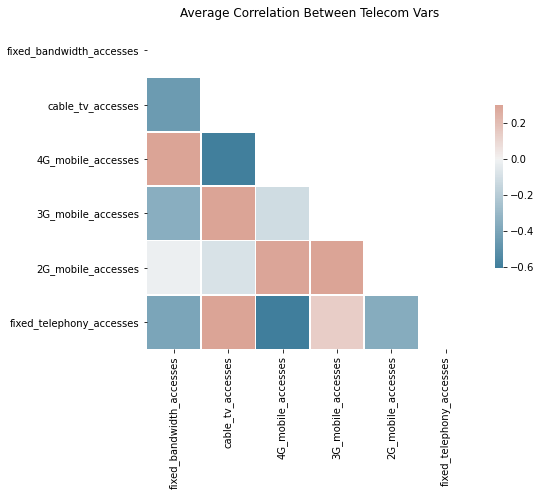

In [10]:
telecom_corr = df[index_cols + telecom_cols]
telecom_corr[telecom_cols] = telecom_corr[telecom_cols].div(df['population'], axis=0)
telecom_corr = telecom_corr.groupby(['city_code']).corr().mean(level=1)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(telecom_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(telecom_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Average Correlation Between Telecom Vars')
plt.show()

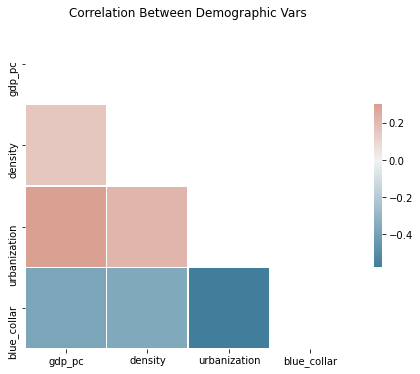

In [11]:
demographic_cols = [
    'gdp_pc',
    'density',
    'urbanization',
    'blue_collar',
]

demographic_corr = df_cities_static[demographic_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(demographic_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(demographic_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Between Demographic Vars')
plt.show()

##### Corrected two-stage OLS model

In [46]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import BetweenOLS

# define types of columns
index_cols = [
    'city_code',
    'date'
]
control_cols = [
    'gdp_pc',
    'density',
    'urbanization',
    'blue_collar',
    'is_SP',
]
telecom_cols = [
    'fixed_bandwidth_accesses',
    'cable_tv_accesses',
    '4G_mobile_accesses',
    '3G_mobile_accesses',
    '2G_mobile_accesses',
    'fixed_telephony_accesses'
]

### stage 1
# define X
X1 = sm.tools.tools.add_constant(df[index_cols + control_cols])
X1[telecom_cols] = (df[telecom_cols].div(df['population'], axis=0)).multiply(df['strict_lockdown'].fillna(0), axis='index')

X1['blue_collar'] = X1['blue_collar'].multiply(df['strict_lockdown'].fillna(0), axis='index')
X1['log(population)'] = np.log(df['population'])

# X1['monday'] = pd.DatetimeIndex(df['date']).weekday == 0
# X1['tuesday'] = pd.DatetimeIndex(df['date']).weekday == 1
# X1['wednesday'] = pd.DatetimeIndex(df['date']).weekday == 2
# X1['thursday'] = pd.DatetimeIndex(df['date']).weekday == 3
# X1['friday'] = pd.DatetimeIndex(df['date']).weekday == 4
# X1['saturday'] = pd.DatetimeIndex(df['date']).weekday == 5

# define y
y1 = df.loc[:, ['city_code', 'date', 'withdrawal_lagged_smooth']]

# apply multi-index to dfs
X1.set_index(['city_code', 'date'], inplace=True)
y1.set_index(['city_code', 'date'], inplace=True)

# run model
stage1 = PanelOLS(y1, X1, entity_effects=False, time_effects=True)
res1 = stage1.fit(cov_type='clustered')
print('First Stage Model:')
print(res1)

### stage 2
# define X
X2 = df.loc[:, ['city_code', 'date'] + control_cols]
X2['log (population)'] = np.log10(df['population'])

X2 = sm.tools.tools.add_constant(X2)
X2 = pd.merge(X2, res1.predict().reset_index(), on=['city_code', 'date'], how='right')

# define y
y2 = df.loc[:, index_cols]
y2['deaths day'] = np.log10((df['deaths_day_smooth']+1)).div(df['population'])
#y2['deaths day'] = df['deaths_day_smooth'].div(df['population'])

# apply multi-index to dfs
X2.set_index(['city_code', 'date'], inplace=True)
y2.set_index(['city_code', 'date'], inplace=True)

# run model
stage2 = PanelOLS(y2, X2, entity_effects=False, time_effects=True)
res2 = stage2.fit(cov_type='clustered')

print('\n\n\nSecond Stage Model:')
print(res2)

First Stage Model:
                             PanelOLS Estimation Summary                              
Dep. Variable:     withdrawal_lagged_smooth   R-squared:                        0.1594
Estimator:                         PanelOLS   R-squared (Between):              0.3831
No. Observations:                     12161   R-squared (Within):              -0.0004
Date:                      Sun, Jun 20 2021   R-squared (Overall):              0.1025
Time:                              00:39:54   Log-likelihood                 2.699e+04
Cov. Estimator:                   Clustered                                           
                                              F-statistic:                      186.98
Entities:                                97   P-value                           0.0000
Avg Obs:                             125.37   Distribution:                F(12,11830)
Min Obs:                             35.000                                           
Max Obs:                